# Bolometric modeling of GW170817

## Imports

In [1]:
from astropy import constants as c
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
from astropy.table import join, Table
from astropy.time import Time
from astropy import units as u
from astropy.utils.data import download_file
import emcee
from ligo.gracedb.rest import GraceDb
from lxml import etree
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import seaborn
%matplotlib inline

## Merger time

LIGO/Virgo merger time in UTC from [GCN 21513](https://gcn.gsfc.nasa.gov/gcn3/21513.gcn3).

In [2]:
t0 = Time(1187008882.443, format='gps').utc
t0.iso

'2017-08-17 12:41:04.443'

## Luminosity distance, distance modulus

Luminosity distance, just off the top of my head.

In [3]:
DL = 40 * u.Mpc

In [4]:
distmod = (5 * np.log10(DL / (10 * u.pc))).value
distmod

33.01029995663981

## GW170817 photometry

Retrieve the light curve from the [Open Kilonova Catalog](https://kilonova.space).

In [5]:
url = 'https://api.kilonova.space/GW170817/photometry/system+upperlimit+time+band+magnitude+e_magnitude?format=csv'
photometry = Table.read(url, format='ascii')

# Keep only data points that are in the AB magnitude system.
photometry = photometry[photometry.columns.pop('system') == 'AB']

# Keep only detections (no upper limits).
photometry = photometry[photometry.columns.pop('upperlimit') == 'F']

# Get rid of entries where the magnitude error is negative or zero.
photometry = photometry[photometry['e_magnitude'] > 0]

# Get rid of unfiltered observations (mostly MASTER).
photometry = photometry[photometry['band'] != 'C']
photometry = photometry[photometry['band'] != 'W']

# Convert to time since merger.
photometry['time'] = (np.asarray(photometry.columns.pop('time')).astype(float) - t0.mjd) * u.day

photometry

band,magnitude,e_magnitude,time
,,,d
str5,float64,float64,float64
i,17.48,0.02,0.45287635416
H,18.26,0.15,0.461676354164
r,17.46,0.03,0.464476354166
Ks,18.62,0.05,0.470476354167
J,17.83,0.15,0.471476354163
V,17.35,0.02,0.471476354163
r,17.33,0.02,0.471476354163
z,17.67,0.03,0.471476354163


## Get filter wavelengths.

Retrieve filter wavelengths from the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/).

**TODO**: Double check these.

In [6]:
filter_longnames = {
    'F110W': 'HST/WFC3_IR.F110W',
    'F160W': 'HST/WFC3_IR.F160W',
    'F336W': 'HST/WFC3_UVIS2.F336W',
    'F475W': 'HST/WFC3_UVIS2.F475W',
    'F606W': 'HST/WFC3_UVIS2.F606W',
    'F625W': 'HST/WFC3_UVIS2.F625W',
    'F775W': 'HST/WFC3_UVIS2.F775W',
    'F814W': 'HST/WFC3_UVIS2.F814W',
    'F850W': 'HST/WFC3_UVIS2.F850LP',
    'B': 'Swift/UVOT.B',
    'U': 'Swift/UVOT.U',
    'V': 'Swift/UVOT.V',
    'W1': 'Swift/UVOT.UVW1',
    'W2': 'Swift/UVOT.UVW2',
    'M2': 'Swift/UVOT.UVM2',
    'H': 'Gemini/Flamingos2.H',
    'I': 'CTIO/DECam.I',
    'Y': 'CTIO/DECam.Y',
    'R': 'CTIO/DECam.R',
    'J': 'Gemini/Flamingos2.J',
    'K': 'Gemini/Flamingos2.Ks',
    'Ks': 'Gemini/Flamingos2.Ks',
    'u': 'SLOAN/SDSS.u',
    'g': 'SLOAN/SDSS.g',
    'r': 'SLOAN/SDSS.r',
    'i': 'SLOAN/SDSS.i',
    'z': 'SLOAN/SDSS.z',
    'y': 'PAN-STARRS/PS1.y',
    'J1': 'LCO/FourStar.J1',
    'w': 'LasCumbres/LasCumbres.PS_w'
}
filter_names = []
filter_wavelengths = []
pattern = 'http://svo2.cab.inta-csic.es/svo/theory/fps3/fps.php?PhotCalID={}/AB&VERB=2'
for name, longname in filter_longnames.items():
    filename = download_file(pattern.format(longname), cache=True)
    tree = etree.parse(filename)
    elem, = tree.iterfind(
        '//{*}PARAM[@name="WavelengthCen"][@unit="Angstrom"]')
    filter_names.append(name)
    filter_wavelengths.append(float(elem.attrib['value']))
filters = Table([filter_names, np.asarray(filter_wavelengths) * u.Angstrom], names=['band', 'wavelength'])
filters.sort('wavelength')
filters

band,wavelength
,Angstrom
str5,float64
W2,1941.22132174
M2,2246.00356226
W1,2604.56916481
F336W,3368.34066118
U,3463.14480935
u,3565.05466331
B,4371.22288257
g,4700.32922202


## Plot light curve

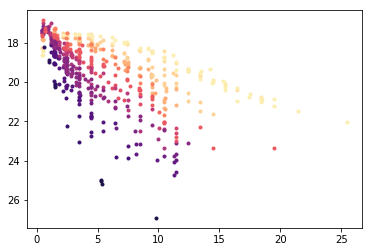

In [7]:
ax = plt.axes()
ax.invert_yaxis()
palette = dict(zip(filters['band'], seaborn.color_palette('magma', len(filters))))
for group in photometry.group_by('band').groups:
    band = group[0]['band']
    ax.plot(group['time'], group['magnitude'], '.', color=palette[band])

## Fit to power law in temperature and radius

In [8]:
def model(x, T1, R1, alpha, beta):
    """Model for an expanding blackbody.

    Parameters
    ----------
    x: tuple, np.array
        The tuple of the time in days and wavelength in angstroms.
    T1: float
        The blackbody temperature in Kelvin at 1 day.
    R1: float
        The blackbody radius in AU at 1 day.
    alpha: float
        The temperature power law index.
    beta: float
        The radius power law index.

    Returns
    -------
    ABmag: float
        The absolute magnitude at the requested time and wavelength.
    """
    t_days, wavelength_angstroms = x
    λ = wavelength_angstroms * u.Angstrom
    T = (T1 * t_days**alpha) * u.Kelvin
    R = (R1 * t_days**beta) * u.au
    fluxdensity = blackbody_lambda(λ, T) * (R / (10 * u.pc))**2 * u.sr
    return fluxdensity.to(u.ABmag, equivalencies=u.spectral_density(λ)).value

data = join(photometry, filters)
x = np.row_stack([
    data['time'].quantity.to(u.day).value,
    data['wavelength'].quantity.to(u.angstrom).value
])
y = np.asarray(data['magnitude']) - distmod
sigma = np.asarray(data['e_magnitude'])

popt, pcov = curve_fit(model, x, y, [1000, 5, 0, 0], sigma)
perr = np.sqrt(np.diag(pcov))
for name, popt_, perr_ in zip(['T1', 'R1', 'a', 'b'], popt, perr):
    print(u'{:2s} = {} ± {}'.format(name, popt_, perr_))

T1 = 5753.212338833728 ± 78.52444811664132
R1 = 89.20693961526759 ± 2.3599867761120703
a  = -0.42114691481667826 ± 0.008458503614396417
b  = 0.4057913547153432 ± 0.018942160477179386


## Plot fit

Text(0,0.5,'$R$ (AU)')

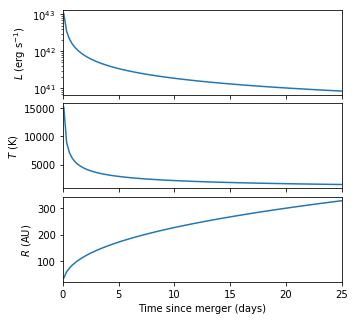

In [9]:
fig = plt.figure(figsize=(5, 5))
gs = GridSpec(3, 1, hspace=0.1)
T1, R1, a, b = popt
t = np.linspace(0.1, 25, 100)
T = T1 * t**a
R = R1 * t**b
L = (c.sigma_sb * (T * u.Kelvin)**4 * 4 * np.pi * (R * u.AU)**2).to(u.erg * u.s**-1).value

ax0 = fig.add_subplot(gs[0])
ax0.plot(t, L)
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax1.plot(t, T)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax2.plot(t, R)

ax0.set_yscale('log')
ax0.set_xlim(0, 25)

plt.setp(ax0.xaxis.get_majorticklabels(), visible=False)
plt.setp(ax1.xaxis.get_majorticklabels(), visible=False)

ax2.set_xlabel('Time since merger (days)')
ax0.set_ylabel(r'$L$ (erg s$^{-1}$)')
ax1.set_ylabel('$T$ (K)')
ax2.set_ylabel('$R$ (AU)')

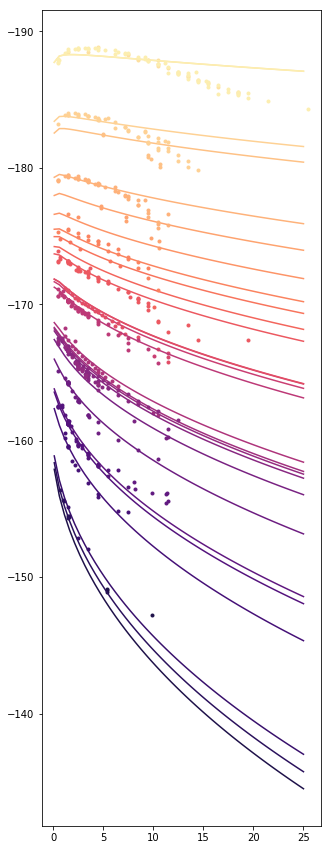

In [10]:
fig = plt.figure(figsize=(5, 15))
ax = plt.axes()
ax.invert_yaxis()
palette = dict(zip(filters['band'], seaborn.color_palette('magma', len(filters))))
for group in data.group_by('band').groups:
    band = group[0]['band']
    wavelength = float(group[0]['wavelength'])
    t = np.linspace(0.1, 25)
    shift = 40 * np.log10(wavelength)
    ax.plot(t, model((t, wavelength), *popt) - shift, color=palette[band])
    # fit = model((np.asarray(group['time']), np.asarray(group['wavelength'])), *popt)
    ax.plot(group['time'], group['magnitude'] - distmod - shift, '.', color=palette[band])

At late times, the fit overpredicts infrared and underpredicts the UV/optical observations.